# EDA for sequencing run

In [2]:
using CSV, DataFrames, CairoMakie, wgregseq, Statistics
num_unique(x) = length(unique(x))
wgregseq.plotting_style.default_makie!()

[ Info: Precompiling wgregseq [57506705-3e72-4664-96ef-b7f153ccca47]


In [3]:
wgregseq.plotting_style.my_color_dict

Dict{String, String} with 15 entries:
  "orange2" => "#fecc96"
  "green3"  => "#e6f0cb"
  "blue2"   => "#8d92c8"
  "blue3"   => "#dbddef"
  "yellow3" => "#fff8c1"
  "purple3" => "#e9d1da"
  "green1"  => "#a8cf38"
  "blue1"   => "#324fa2"
  "yellow1" => "#fce317"
  "green2"  => "#d1e39b"
  "yellow2" => "#fff182"
  "orange1" => "#f47c20"
  "purple1" => "#9f2260"
  "purple2" => "#cca6b6"
  "orange3" => "#ffe4c6"

## Standard Deviation between barcodes of same promoter sequence

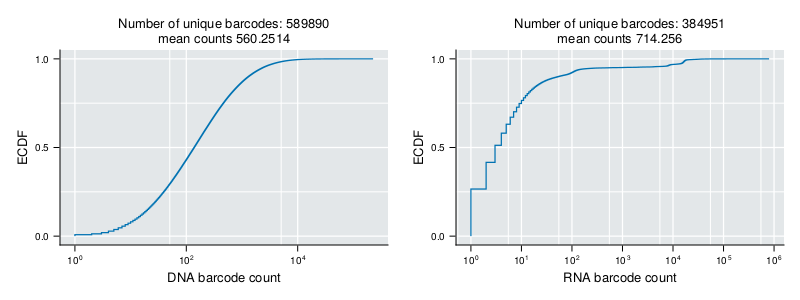

In [12]:
df = CSV.read(
    "../../../data/LB_barcodes.csv", 
    DataFrame);
insertcols!(df, 1, :relative_counts => (df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))

fig = Figure(resolution=(800, 300))

ax = Axis(fig[1, 1], xlabel="DNA barcode count", ylabel="ECDF", xscale=log10)
x = filter(x -> x > 0, df.ct_0) |> sort
lines!(ax, x, 1/length(x):1/length(x):1)
ax.title = "Number of unique barcodes: $(length(x))\nmean counts $(round(mean(x), digits=4))"

ax = Axis(fig[1, 2], xlabel="RNA barcode count", ylabel="ECDF", xscale=log10)
x = filter(x -> x > 0, df.ct_1) |> sort
lines!(ax, x, 1/length(x):1/length(x):1)
ax.title = "Number of unique barcodes: $(length(x))\nmean counts $(round(mean(x), digits=4))"

fig

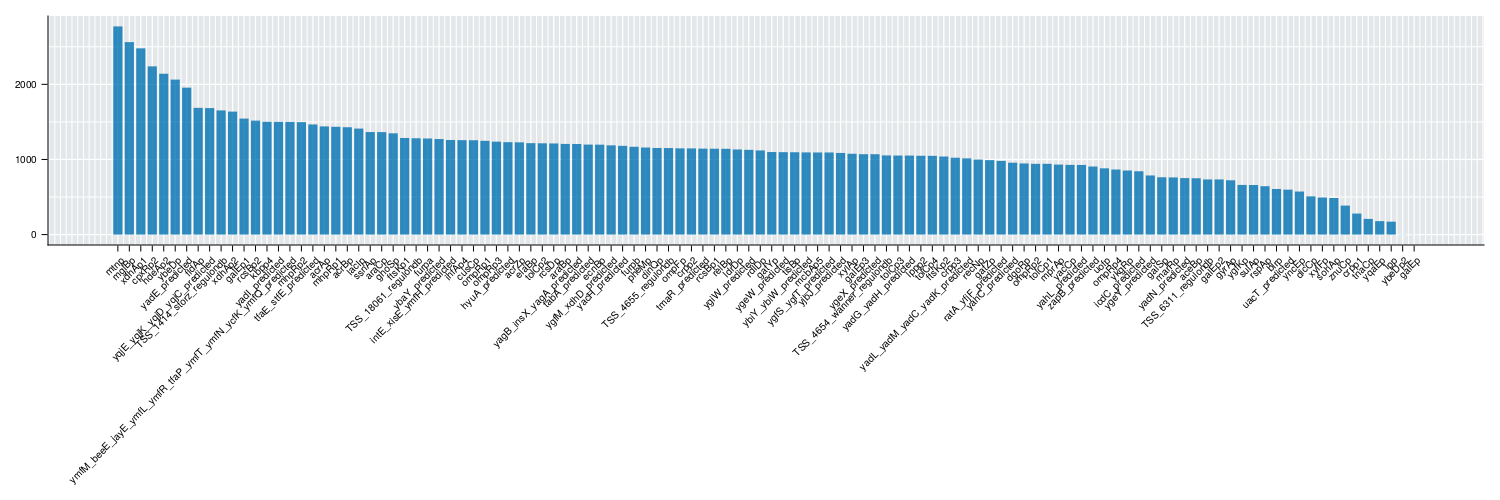

In [33]:
gdf = groupby(df, [:promoter, :name])
df_list = []
for _df in gdf
    if nrow(_df) > 1
        push!(df_list, _df)
    end
end
_df = vcat(df_list...)
_df = combine(groupby(_df, :name), :promoter => num_unique)
sort!(_df, :promoter_num_unique, rev=true)
fig = Figure(resolution=(1500, 500))
ax = Axis(fig[1, 1], xticklabelrotation=π/4,xticks=(1:nrow(_df), _df.name))
barplot!(ax, _df.promoter_num_unique)
save("20221104_unique_promoters_l1.pdf", fig)
fig

## Bardode Bias

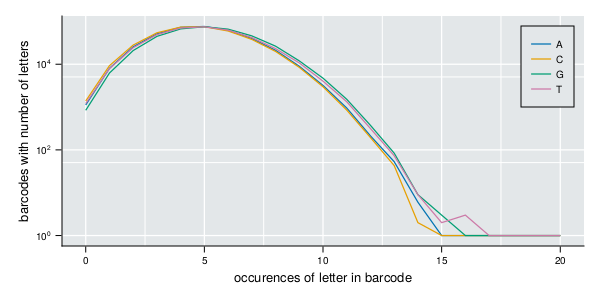

In [18]:
count_letter(seq, x) = sum(map(c -> c == x, collect(seq)))


fig = Figure(resolution=(600, 300))
ax2 = Axis(fig[1, 1], yscale=log10)
ax2.ylabel = "barcodes with number of letters"
ax2.xlabel = "occurences of letter in barcode"

function med(x)
    if length(x) == 0
        return 0
    else
        return median(x)
    end
end

for letter in ['A', 'C', 'G', 'T']
    tot = map(x -> count_letter(x, letter), df.barcode)
    lines!(ax2, 0:20, [sum(tot .== i) for i in 0:20] .+ 1, label=string(letter))
end
axislegend(ax2, position=:rt)
fig

## Barcode counts ranked

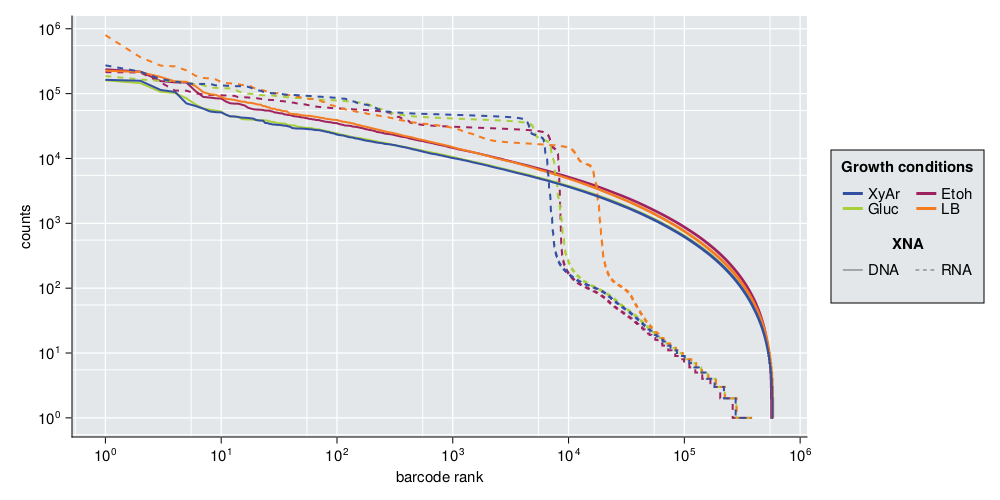

In [22]:
fig = Figure(resolution=(1000, 500))
ax = Axis(
    fig[1, 1],
    xlabel="barcode rank",
    ylabel="counts",
    yscale=log10,
    xscale=log10
    )

color_dict = Dict(
    "LB"=>wgregseq.plotting_style.my_color_dict["orange1"],
    "Etoh"=>wgregseq.plotting_style.my_color_dict["purple1"],
    "Gluc"=>wgregseq.plotting_style.my_color_dict["green1"],
    "XyAr"=>wgregseq.plotting_style.my_color_dict["blue1"]
)

style_dict = Dict(
    "gDNA"=>:solid,
    "cDNA"=>:dash
)

for file in [
        "Etoh_barcodes.csv",
        "Gluc_barcodes.csv",
        "LB_barcodes.csv",
        "XyAr_barcodes.csv"
        ]
        

    df = CSV.read(
        "../../../data/"*file, 
        DataFrame,  
        )
    gc = split(file, '_')[1]
    lines!(
        ax, 
        sort(df[df.ct_0 .> 0, :ct_0], rev=true),
        color=color_dict[gc],
        linestyle=style_dict["gDNA"],
        linewidth=2
    )
    lines!(
        ax, 
        sort(df[df.ct_1 .> 0, :ct_1], rev=true),
        color=color_dict[gc],
        linestyle=style_dict["cDNA"],
        linewidth=2
    )
end
ax.yticklabelsize = 15
ax.xticklabelsize = 15
ax.xlabelsize = 15
ax.ylabelsize = 15
growth_conditions = keys(color_dict) |> collect
growth_conditions_lines = [LineElement(color = color_dict[gc], linewidth=3) for gc in growth_conditions]

group_color = [
    LineElement(color = :gray, linestyle=:solid),
    LineElement(color = :gray, linestyle=:dash),
    LineElement(color = :gray, linestyle=:solid, linewidth=0),
    LineElement(color = :gray, linestyle=:solid, linewidth=0)
]



legends = Legend(fig,
    [growth_conditions_lines, group_color],
    [growth_conditions, ["DNA", "RNA", " ", " "]],
    ["Growth conditions", "XNA"],
    nbanks=2,
    titlesize=15,
    labelsize=15
    
)
fig[1, 2] = legends
#axislegend(ax)
fig

## Variants per promoter identified

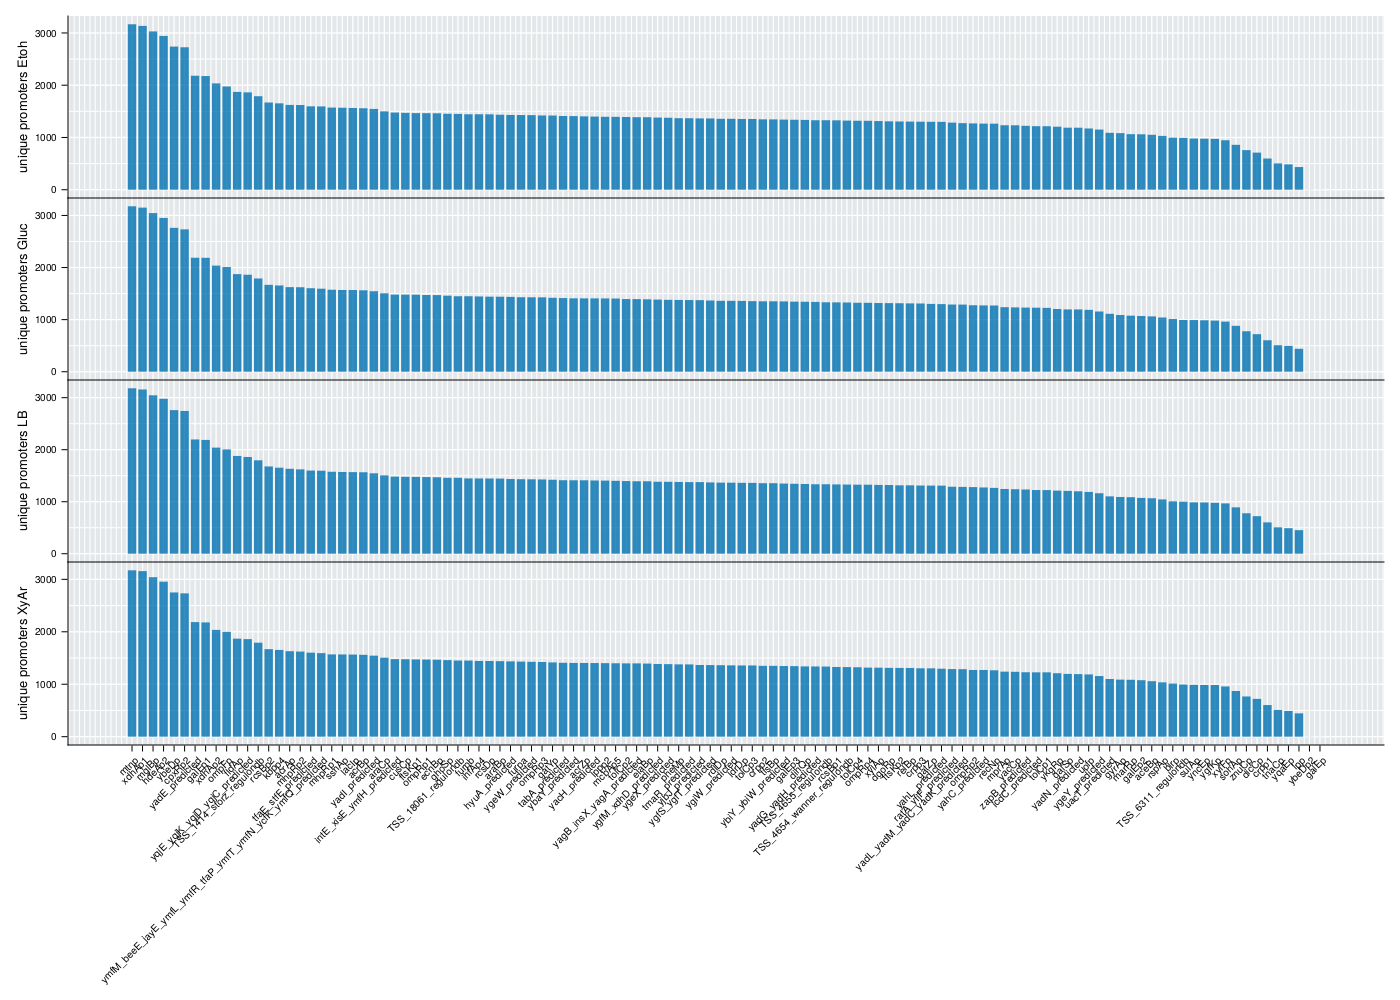

In [30]:
fig = Figure(resolution=(1400, 1000))
ax_0 = fig[1, 1] = GridLayout()
for (i, file) in enumerate([
        "Etoh_barcodes.csv",
        "Gluc_barcodes.csv",
        "LB_barcodes.csv",
        "XyAr_barcodes.csv"
        ])
    df = CSV.read(
            "../../../data/"*file, 
            DataFrame, 
            )
    num_unique(x) = length(unique(x))

    found_promoters_df = sort(combine(groupby(df, :name), :promoter => num_unique), :promoter_num_unique, rev=true)
    if i == 4
        ax = Axis(ax_0[i, 1], xticks = (1:nrow(found_promoters_df), found_promoters_df.name), xticklabelrotation=pi/4)
    else
        ax = Axis(ax_0[i, 1], xticks = (1:nrow(found_promoters_df)), xticksize=0, xticklabelsize=0)
    end
    barplot!(ax, found_promoters_df.promoter_num_unique)
    ax.ylabel = "unique promoters $(split(file, '_')[1])"
    #ax.title = "Growth condition: $(split(file, '_')[1])"
end
rowgap!(ax_0, 0)
fig

## How many barcodes per promoter?

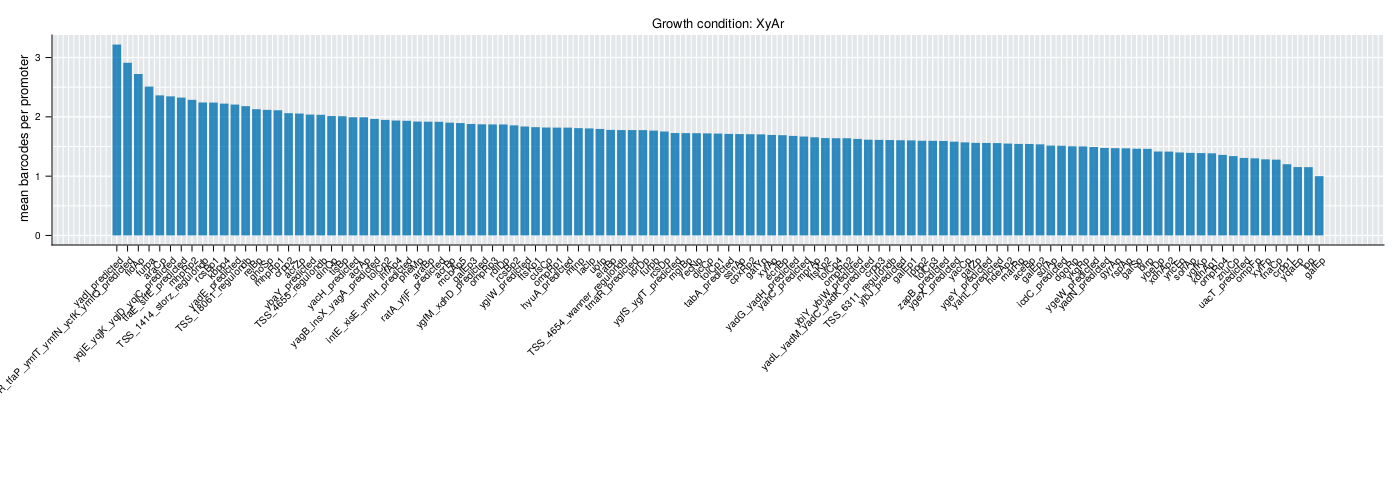

In [45]:
gc = "XyAr"
df = CSV.read(
        "../../../data/extracted_barcodes/20221114_barcode/$(gc)_identified.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        )

num_unique(x) = length(unique(x))

df = combine(groupby(df, [:name, :promoter]), :barcode => num_unique)
df = sort(combine(groupby(df, [:name]), :barcode_num_unique => mean), :barcode_num_unique_mean, rev=true)

fig = Figure(resolution=(1400, 500))
ax = Axis(fig[1, 1], xticks = (1:nrow(df), df.name), xticklabelrotation=pi/4)
barplot!(ax, df.barcode_num_unique_mean)
ax.ylabel = " mean barcodes per promoter"
ax.title = "Growth condition: $gc"
fig

## Counts per barcode 

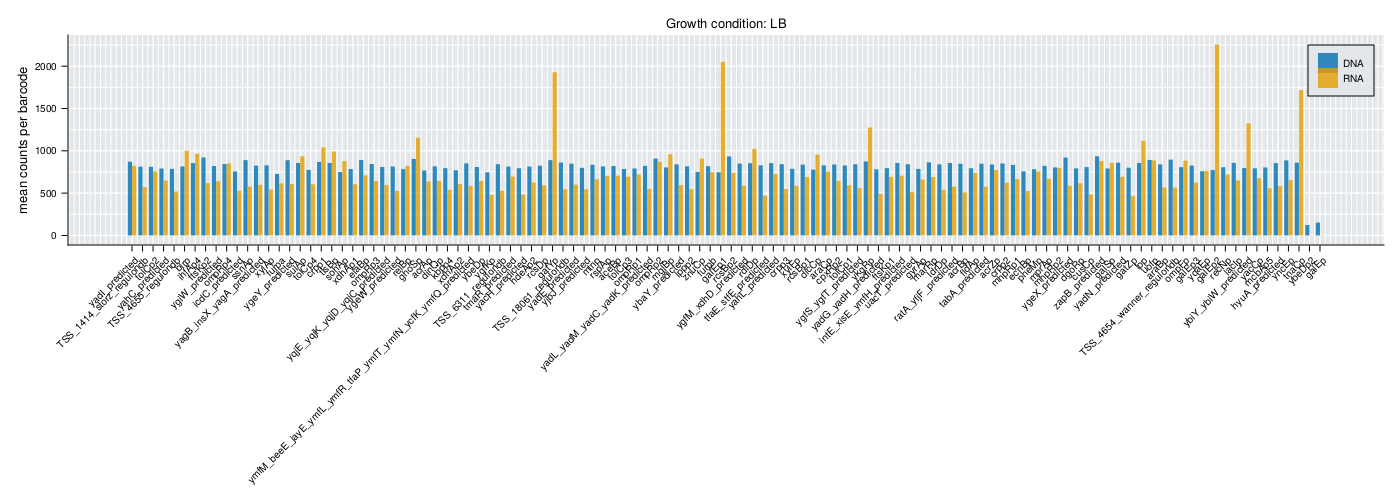

In [81]:
gc = "LB"
df = CSV.read(
        "../../../data/extracted_barcodes/20221114_barcode/$(gc)_identified.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        )

num_unique(x) = length(unique(x))

df = combine(groupby(df, :name), [:gDNA_count, :cDNA_count] =>
               ((p, s) -> (mean_gDNA=mean(p), mean_cDNA=mean(s), std_gDNA=std(p), std_cDNA=std(s))) =>
               AsTable)

fig = Figure(resolution=(1400, 500))
ax = Axis(fig[1, 1], xticks = (1:nrow(df), df.name), xticklabelrotation=pi/4)
barplot!(ax, collect(1:nrow(df)) .- 0.2, df.mean_gDNA, width=0.5, label="DNA")
barplot!(ax, collect(1:nrow(df)) .+ 0.2, df.mean_cDNA, width=0.5, label="RNA")
axislegend(ax)
ax.ylabel = "mean counts per barcode"
ax.title = "Growth condition: $gc"
fig

## gDNA counts across growth conditions

In [1]:
gcs = ["LB", "Etoh", "Gluc", "XyAr"]

df_list = [
    df = CSV.read(
    "../../../data/$(i)_barcodes.csv", 
    DataFrame, 
    ignorerepeated=true, 
    delim=" ", 
    )
    for i in gcs]

fig_list=[]

highlight = "rspAp"

for j in 1:length(gcs)
    for i in j+1:length(gcs)
        fig = Figure(resolution=(1200, 300))
        ax_DNA = Axis(fig[1, 1], yscale=log10, xscale=log10)
        ax_RNA = Axis(fig[1, 2], yscale=log10, xscale=log10)
        ax_rel = Axis(fig[1, 3], yscale=log10, xscale=log10)

        ax_DNA.xlabel = gcs[j]
        ax_DNA.ylabel = gcs[i]
        ax_DNA.title = "gDNA"
        
        ax_RNA.xlabel = gcs[j]
        ax_RNA.ylabel = gcs[i]
        ax_RNA.title = "cDNA"
        
        ax_rel.xlabel = gcs[j]
        ax_rel.ylabel = gcs[i]
        ax_rel.title = "relative counts"

        _df = innerjoin(df_list[j], df_list[i], on=:barcode, makeunique=true)
        f1 = _df[(_df.gDNA_count .> 0) .& (_df.gDNA_count_1 .> 0), :]
        f2 = _df[(_df.cDNA_count .> 0) .& (_df.cDNA_count_1 .> 0), :]
        f3 = _df[(_df.cDNA_count .> 0) .& (_df.cDNA_count_1 .> 0) .& (_df.gDNA_count .> 0) .& (_df.gDNA_count_1 .> 0), :]
        
        scatter!(ax_DNA, f1.gDNA_count, f1.gDNA_count_1, markersize=2)
        scatter!(ax_RNA, f2.cDNA_count, f2.cDNA_count_1, markersize=2)
        scatter!(ax_rel, f3.cDNA_count ./ f3.gDNA_count, f3.cDNA_count_1 ./ f3.gDNA_count_1, markersize=2)
        
        f1 = _df[(_df.gDNA_count .> 0) .& (_df.gDNA_count_1 .> 0) .& (_df.name .== highlight), :]
        f2 = _df[(_df.cDNA_count .> 0) .& (_df.cDNA_count_1 .> 0) .& (_df.name .== highlight), :]
        f3 = _df[(_df.cDNA_count .> 0) .& (_df.cDNA_count_1 .> 0) .& (_df.gDNA_count .> 0) .& (_df.gDNA_count_1 .> 0) .& (_df.name .== highlight), :]
        
        scatter!(ax_DNA, f1.gDNA_count, f1.gDNA_count_1, markersize=2)
        scatter!(ax_RNA, f2.cDNA_count, f2.cDNA_count_1, markersize=2)
        scatter!(ax_rel, f3.cDNA_count ./ f3.gDNA_count, f3.cDNA_count_1 ./ f3.gDNA_count_1, markersize=2)
        
        #save("figures/$(gcs[j])_$(gcs[i])_counts_compare.pdf", fig)
        push!(fig_list, fig)
    end
end

LoadError: UndefVarError: CSV not defined

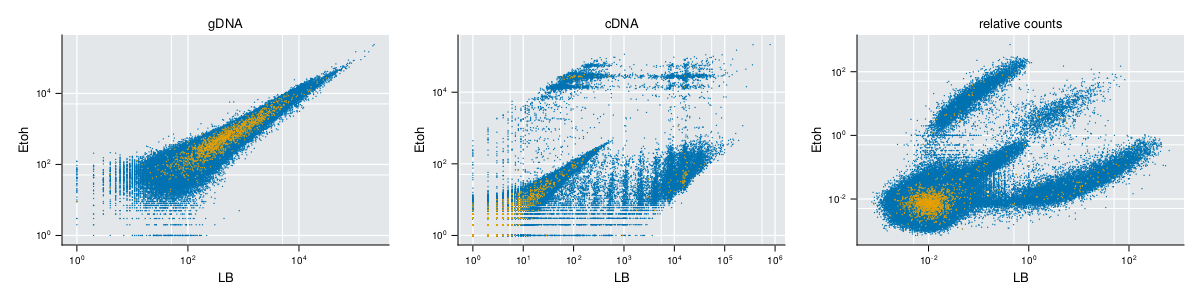

In [151]:
fig_list[1]

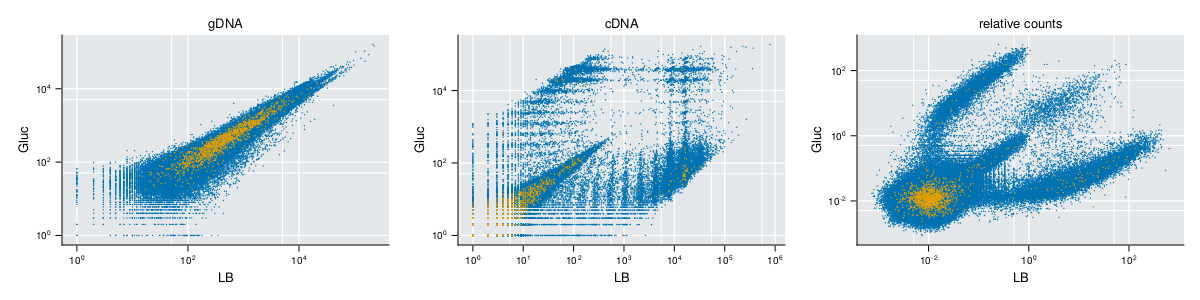

In [152]:
fig_list[2]

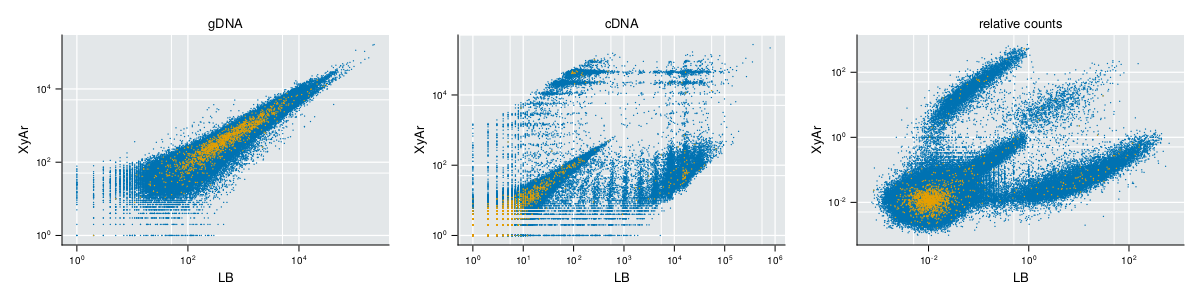

In [153]:
fig_list[3]

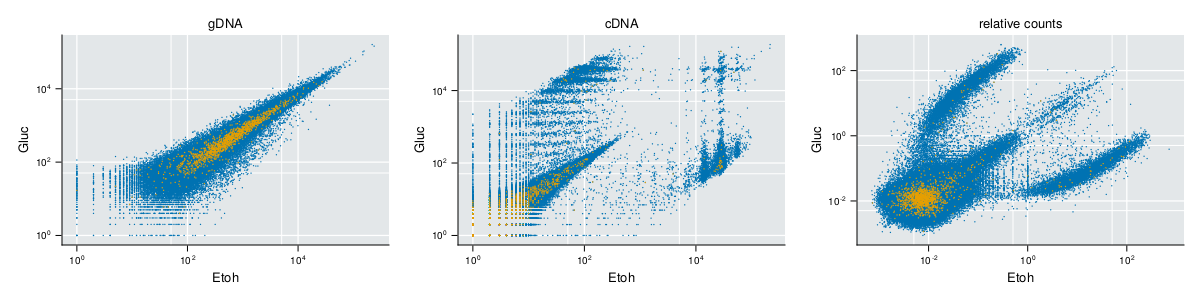

In [154]:
fig_list[4]

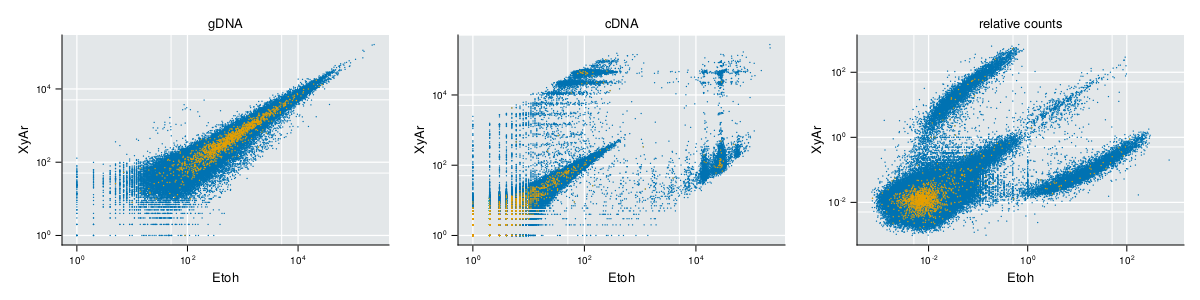

In [155]:
fig_list[5]

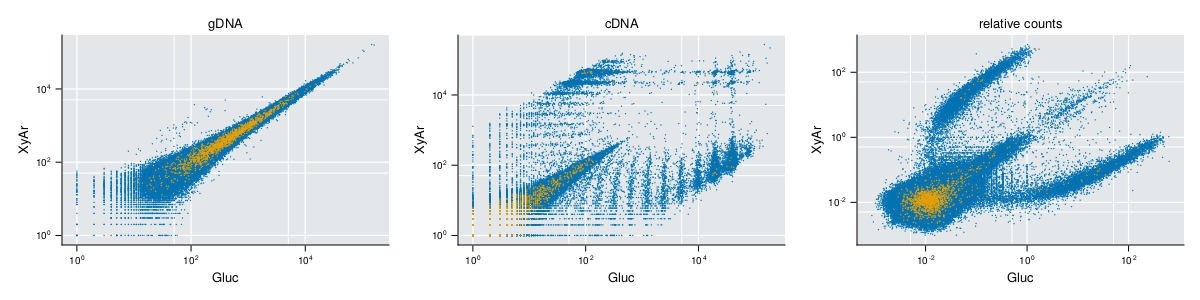

In [156]:
fig_list[6]